# **Importing required libraries**

In [38]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# **Datasets Loading**

In [2]:
flight_data = pd.read_csv('flight_information.csv')
ground_data = pd.read_csv('ground_information.csv')

flight_data.info()
ground_data.info()

flight_data.head(), ground_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12017 entries, 0 to 12016
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          12017 non-null  int64  
 1   leg_no              12017 non-null  int64  
 2   fn_carrier          12017 non-null  object 
 3   fn_number           12017 non-null  object 
 4   dep_ap_sched        12017 non-null  object 
 5   arr_ap_sched        12017 non-null  object 
 6   dep_sched_date      12017 non-null  object 
 7   dep_sched_time      12017 non-null  object 
 8   arr_sched_date      12017 non-null  object 
 9   arr_sched_time      12017 non-null  object 
 10  m_offblockdt        12017 non-null  object 
 11  m_onblockdt         11934 non-null  object 
 12  ac_registration     12017 non-null  object 
 13  change_reason_code  12017 non-null  object 
 14  dep_delay           12017 non-null  float64
 15  Ac Type Code        12017 non-null  object 
 16  tran

(   Unnamed: 0     leg_no            fn_carrier fn_number      dep_ap_sched  \
 0           0  272005011  East Carmen Airlines    EC3098     North Gregory   
 1           1  272009188  East Carmen Airlines    EC3146        Port Bobby   
 2           2  271984537  East Carmen Airlines    EC2840         Port Ryan   
 3           3  272025831  East Carmen Airlines    EC3306          Coleland   
 4           4  272006092  East Carmen Airlines    EC3114  East Melissaberg   
 
   arr_ap_sched dep_sched_date dep_sched_time arr_sched_date arr_sched_time  \
 0  East Carmen     2019-06-01          00:40     2019-06-01          04:30   
 1  East Carmen     2019-06-01          02:05     2019-06-01          04:00   
 2  East Carmen     2019-06-01          02:20     2019-06-01          03:50   
 3  East Carmen     2019-06-01          02:25     2019-06-01          04:00   
 4  East Carmen     2019-06-01          02:30     2019-06-01          04:15   
 
    ... change_reason_code dep_delay Ac Type Cod

In [3]:
print("Flight Data Columns:", flight_data.columns)
print("Ground Data Columns:", ground_data.columns)

Flight Data Columns: Index(['Unnamed: 0', 'leg_no', 'fn_carrier', 'fn_number', 'dep_ap_sched',
       'arr_ap_sched', 'dep_sched_date', 'dep_sched_time', 'arr_sched_date',
       'arr_sched_time', 'm_offblockdt', 'm_onblockdt', 'ac_registration',
       'change_reason_code', 'dep_delay', 'Ac Type Code', 'trans_time',
       'sched_trans_time', 'Crew Group', 'TLC_trans', 'crew_type_change',
       'Sched Groundtime', 'Act Groundtime'],
      dtype='object')
Ground Data Columns: Index(['Unnamed: 0', 'day_of_origin', 'ac_type', 'fn_number',
       'ac_registration', 'mingt', 'dep_leg_inbound', 'arr_leg_inbound',
       'arr_leg_outbound', 'sched_inbound_dep', 'sched_inbound_arr',
       'sched_outbound_dep', 'sched_outbound_arr', 'sched_turnaround',
       'leg_inbound', 'leg_outbound', 'catering_duration', 'cleaning_duration',
       'pax_boarding_duration'],
      dtype='object')


# **Merge both datasets**

In [4]:
flight_data['leg_no'] = flight_data['leg_no'].astype(int)
ground_data['leg_inbound'] = ground_data['leg_inbound'].astype(int)
ground_data['leg_outbound'] = ground_data['leg_outbound'].astype(int)

print(flight_data['leg_no'].isin(ground_data['leg_inbound']).sum())
print(flight_data['leg_no'].isin(ground_data['leg_outbound']).sum())

4145
4109


In [5]:
# merge on 'leg_inbound'
merged_inbound = pd.merge(flight_data, ground_data, left_on='leg_no', right_on='leg_inbound', how='inner')

# merge on 'leg_outbound'
merged_outbound = pd.merge(flight_data, ground_data, left_on='leg_no', right_on='leg_outbound', how='inner')

merged_data_combined = pd.concat([merged_inbound, merged_outbound]).drop_duplicates()
merged_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8380 entries, 0 to 4150
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0_x           8380 non-null   int64  
 1   leg_no                 8380 non-null   int64  
 2   fn_carrier             8380 non-null   object 
 3   fn_number_x            8380 non-null   object 
 4   dep_ap_sched           8380 non-null   object 
 5   arr_ap_sched           8380 non-null   object 
 6   dep_sched_date         8380 non-null   object 
 7   dep_sched_time         8380 non-null   object 
 8   arr_sched_date         8380 non-null   object 
 9   arr_sched_time         8380 non-null   object 
 10  m_offblockdt           8380 non-null   object 
 11  m_onblockdt            8379 non-null   object 
 12  ac_registration_x      8380 non-null   object 
 13  change_reason_code     8380 non-null   object 
 14  dep_delay              8380 non-null   float64
 15  Ac Type C

# **Missing data handling**

In [6]:
missing_values = merged_data_combined.isnull().sum()
print(missing_values[missing_values > 0])

m_onblockdt                 1
Sched Groundtime          932
Act Groundtime            933
arr_leg_outbound            6
cleaning_duration        8374
pax_boarding_duration     807
dtype: int64


In [7]:
# drop row where 'm_onblockdt' is missing
merged_data_combined = merged_data_combined.dropna(subset=['m_onblockdt'])

# missing values for numerical columns
merged_data_combined.loc[:, 'Sched Groundtime'] = merged_data_combined['Sched Groundtime'].fillna(merged_data_combined['Sched Groundtime'].median())
merged_data_combined.loc[:, 'Act Groundtime'] = merged_data_combined['Act Groundtime'].fillna(merged_data_combined['Act Groundtime'].median())
merged_data_combined.loc[:, 'pax_boarding_duration'] = merged_data_combined['pax_boarding_duration'].fillna(merged_data_combined['pax_boarding_duration'].median())

# missing values for categorical column
merged_data_combined.loc[:, 'arr_leg_outbound'] = merged_data_combined['arr_leg_outbound'].fillna(merged_data_combined['arr_leg_outbound'].mode()[0])

# drop 'cleaning_duration' column due to too many missing values
merged_data_combined = merged_data_combined.drop(columns=['cleaning_duration'])

# verify missing values are handled
missing_values_after = merged_data_combined.isnull().sum()
print("Missing values after handling:", missing_values_after[missing_values_after > 0])

Missing values after handling: Series([], dtype: int64)


# **Data Transformation**

In [8]:
print(merged_data_combined.columns)

Index(['Unnamed: 0_x', 'leg_no', 'fn_carrier', 'fn_number_x', 'dep_ap_sched',
       'arr_ap_sched', 'dep_sched_date', 'dep_sched_time', 'arr_sched_date',
       'arr_sched_time', 'm_offblockdt', 'm_onblockdt', 'ac_registration_x',
       'change_reason_code', 'dep_delay', 'Ac Type Code', 'trans_time',
       'sched_trans_time', 'Crew Group', 'TLC_trans', 'crew_type_change',
       'Sched Groundtime', 'Act Groundtime', 'Unnamed: 0_y', 'day_of_origin',
       'ac_type', 'fn_number_y', 'ac_registration_y', 'mingt',
       'dep_leg_inbound', 'arr_leg_inbound', 'arr_leg_outbound',
       'sched_inbound_dep', 'sched_inbound_arr', 'sched_outbound_dep',
       'sched_outbound_arr', 'sched_turnaround', 'leg_inbound', 'leg_outbound',
       'catering_duration', 'pax_boarding_duration'],
      dtype='object')


In [9]:
# convert 'dep_sched_date' and 'arr_sched_date' to datetime
merged_data_combined['dep_sched_date'] = pd.to_datetime(merged_data_combined['dep_sched_date'])
merged_data_combined['arr_sched_date'] = pd.to_datetime(merged_data_combined['arr_sched_date'])

# convert categorical columns to category type
merged_data_combined['ac_type'] = merged_data_combined['ac_type'].astype('category')
merged_data_combined['Crew Group'] = merged_data_combined['Crew Group'].astype('category')

# verify the data types after conversion
print(merged_data_combined.dtypes)

Unnamed: 0_x                      int64
leg_no                            int64
fn_carrier                       object
fn_number_x                      object
dep_ap_sched                     object
arr_ap_sched                     object
dep_sched_date           datetime64[ns]
dep_sched_time                   object
arr_sched_date           datetime64[ns]
arr_sched_time                   object
m_offblockdt                     object
m_onblockdt                      object
ac_registration_x                object
change_reason_code               object
dep_delay                       float64
Ac Type Code                     object
trans_time                        int64
sched_trans_time                  int64
Crew Group                     category
TLC_trans                        object
crew_type_change                 object
Sched Groundtime                float64
Act Groundtime                  float64
Unnamed: 0_y                      int64
day_of_origin                    object


In [31]:
# convert datetime columns to numerical features before one-hot encoding
for col in ['arr_sched_time', 'm_onblockdt', 'dep_sched_date', 'arr_sched_date']:
    if col in merged_data_combined.columns:
        merged_data_combined[col] = merged_data_combined[col].astype(int) / 10**9

# **Basic Consistency Checks**

In [10]:
# if actual ground time is larger than scheduled ground time
inconsistent_groundtime = merged_data_combined[merged_data_combined['Act Groundtime'] > merged_data_combined['Sched Groundtime']]
inconsistent_groundtime.head()

,Unnamed: 0_x,leg_no,fn_carrier,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,...,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,pax_boarding_duration
1,7,272027070,East Carmen Airlines,EC3316,East Latashaview,East Carmen,2019-06-01,03:15,2019-06-01,07:05,...,Juliemouth,2019-06-01 03:15:00,2019-06-01 07:05:00,2019-06-01 07:50:00,2019-06-01 12:05:00,45,272027070,272029306,27,15.0
3,13,272034482,East Carmen Airlines,EC3420,East Allisontown,East Carmen,2019-06-01,04:00,2019-06-01,04:35,...,Yoderburgh,2019-06-01 04:00:00,2019-06-01 04:35:00,2019-06-01 05:30:00,2019-06-01 07:05:00,55,272034482,271961698,18,11.0
5,19,272212666,East Carmen Airlines,EC3256,Matthewland,East Carmen,2019-06-01,04:25,2019-06-01,06:05,...,Richardsonburgh,2019-06-01 04:25:00,2019-06-01 06:05:00,2019-06-01 07:20:00,2019-06-01 09:50:00,75,272212666,272100407,22,15.0
7,26,271980424,East Carmen Airlines,EC2788,Castroville,East Carmen,2019-06-01,04:45,2019-06-01,07:10,...,Lake David,2019-06-01 04:45:00,2019-06-01 07:10:00,2019-06-01 07:50:00,2019-06-01 09:40:00,40,271980424,272002934,17,21.0
8,30,272016390,East Carmen Airlines,EC3224,Youngland,East Carmen,2019-06-01,04:55,2019-06-01,06:40,...,Youngland,2019-06-01 04:55:00,2019-06-01 06:40:00,2019-06-01 08:10:00,2019-06-01 09:45:00,90,272016390,272018760,29,32.0


In [11]:
merged_data_combined = merged_data_combined[merged_data_combined['Act Groundtime'] <= merged_data_combined['Sched Groundtime']]

In [12]:
datetime_format = "%Y-%m-%d %H:%M:%S"

merged_data_combined['arr_sched_time'] = pd.to_datetime(
    merged_data_combined['arr_sched_time'], format=datetime_format, errors='coerce'
)
merged_data_combined['m_onblockdt'] = pd.to_datetime(
    merged_data_combined['m_onblockdt'], format=datetime_format, errors='coerce'
)

# calculate delay
merged_data_combined['arr_delay'] = (
    merged_data_combined['m_onblockdt'] - merged_data_combined['arr_sched_time']
).dt.total_seconds() / 60

In [13]:
print(merged_data_combined[['arr_sched_time', 'm_onblockdt', 'arr_delay']].head())

   arr_sched_time         m_onblockdt  arr_delay
0             NaT 2019-06-01 04:43:00        NaN
2             NaT 2019-06-01 07:01:00        NaN
4             NaT 2019-06-01 04:57:00        NaN
6             NaT 2019-06-01 07:03:00        NaN
14            NaT 2019-06-01 07:15:00        NaN


# **Exploratory Data Analysis**

1. Distribution of Departure and Arrival Delays

In [14]:
# departure delay distribution
fig_dep_delay = px.histogram(merged_data_combined, x='dep_delay', nbins=50,
                              title="Distribution of Departure Delays",
                              labels={'dep_delay': 'Departure Delay (minutes)'},
                              template="plotly_white")

fig_dep_delay.update_layout(
    xaxis_title="Delay (minutes)",
    yaxis_title="Count"
)
fig_dep_delay.show()

# arrival delay distribution
fig_arr_delay = px.histogram(merged_data_combined, x='arr_delay', nbins=50,
                              title="Distribution of Arrival Delays",
                              labels={'arr_delay': 'Arrival Delay (minutes)'},
                              template="plotly_white")

fig_arr_delay.update_layout(
    xaxis_title="Delay (minutes)",
    yaxis_title="Count"
)
fig_arr_delay.show()

2. Scheduled vs. Actual Ground Time Comparison

In [15]:
fig_groundtime_comparison = px.scatter(merged_data_combined, x="Sched Groundtime", y="Act Groundtime",
                                       color="fn_carrier", hover_data=["leg_no"],
                                       title="Scheduled vs. Actual Ground Time",
                                       labels={'Sched Groundtime': 'Scheduled Ground Time (minutes)',
                                               'Act Groundtime': 'Actual Ground Time (minutes)'},
                                       template="plotly_white")

fig_groundtime_comparison.update_layout(
    xaxis_title="Scheduled Ground Time (minutes)",
    yaxis_title="Actual Ground Time (minutes)"
)
fig_groundtime_comparison.show()

3. Turnaround Time (Scheduled vs. Actual)

In [16]:
merged_data_combined['turnaround_time'] = (merged_data_combined['dep_sched_date'] - merged_data_combined['arr_sched_date']).dt.total_seconds() / 60

fig_turnaround_time = px.box(merged_data_combined, x="fn_carrier", y="turnaround_time", color="fn_carrier",
                             title="Turnaround Time by Carrier",
                             labels={'turnaround_time': 'Turnaround Time (minutes)', 'fn_carrier': 'Carrier'},
                             template="plotly_white")

fig_turnaround_time.update_layout(
    yaxis_title="Turnaround Time (minutes)"
)
fig_turnaround_time.show()

4. Delay and Ground Time Correlation Heatmap

In [17]:
corr_matrix = merged_data_combined[['dep_delay', 'arr_delay', 'Sched Groundtime', 'Act Groundtime', 'turnaround_time']].corr()

fig_corr = px.imshow(corr_matrix, text_auto=True, aspect="auto", title="Correlation Heatmap",
                     template="plotly_white")
fig_corr.show()

5. Track delays over time

In [18]:
fig_delay_time = px.line(merged_data_combined, x='dep_sched_date', y='dep_delay',
                         title="Departure Delays Over Time",
                         labels={'dep_sched_date': 'Date', 'dep_delay': 'Departure Delay (minutes)'},
                         template="plotly_white")
fig_delay_time.show()

# **Saving cleaned dataset**

In [19]:
merged_data_combined.to_csv('cleaned_dataset.csv', index=False)

# **Feature Engineering**

Is flight delayed over 15 minutes?

In [22]:
merged_data_combined['target_delay'] = (merged_data_combined['dep_delay'] > 15).astype(int)

Extract temporal features from dep_sched_date

In [23]:
merged_data_combined['dep_weekday'] = merged_data_combined['dep_sched_date'].dt.dayofweek
merged_data_combined['dep_hour'] = merged_data_combined['dep_sched_date'].dt.hour
merged_data_combined['dep_month'] = merged_data_combined['dep_sched_date'].dt.month
merged_data_combined['is_weekend'] = merged_data_combined['dep_weekday'].isin([5, 6]).astype(int)

Crew change flag

In [24]:
merged_data_combined['crew_change_flag'] = (merged_data_combined['Crew Group'].shift() != merged_data_combined['Crew Group']).astype(int)

One-hot encode categorical variables

In [25]:
categorical_cols = ['ac_type', 'Crew Group']
merged_data_encoded = pd.get_dummies(merged_data_combined, columns=categorical_cols, drop_first=True)

Drop columns that won’t be used directly in modeling

In [26]:
drop_cols = [
    'dep_sched_date', 'arr_sched_date', 'arr_sched_time', 'm_onblockdt',
    'leg_no', 'leg_inbound', 'leg_outbound', 'fn_carrier'
]
merged_data_encoded = merged_data_encoded.drop(columns=drop_cols, errors='ignore')

Final check

In [32]:
for col in ['arr_sched_time', 'm_onblockdt', 'dep_sched_date', 'arr_sched_date']:
    if col in merged_data_combined.columns:
        merged_data_combined[col] = merged_data_combined[col].astype(int) / 10**9

In [ ]:
merged_data_combined['dep_sched_date'] = pd.to_datetime(merged_data_combined['dep_sched_date'])
merged_data_combined['arr_sched_date'] = pd.to_datetime(merged_data_combined['arr_sched_date'])

merged_data_combined['ac_type'] = merged_data_combined['ac_type'].astype('category')
merged_data_combined['Crew Group'] = merged_data_combined['Crew Group'].astype('category')

print(merged_data_combined.dtypes)

Unnamed: 0_x                      int64
leg_no                            int64
fn_carrier                       object
fn_number_x                      object
dep_ap_sched                     object
arr_ap_sched                     object
dep_sched_date           datetime64[ns]
dep_sched_time                   object
arr_sched_date           datetime64[ns]
arr_sched_time                   object
m_offblockdt                     object
m_onblockdt                      object
ac_registration_x                object
change_reason_code               object
dep_delay                       float64
Ac Type Code                     object
trans_time                        int64
sched_trans_time                  int64
Crew Group                     category
TLC_trans                        object
crew_type_change                 object
Sched Groundtime                float64
Act Groundtime                  float64
Unnamed: 0_y                      int64
day_of_origin                    object


In [27]:
print("Final shape after feature engineering:", merged_data_encoded.shape)
print("Sample columns:", merged_data_encoded.columns.tolist()[:15])
print("Target distribution:")
print(merged_data_encoded['target_delay'].value_counts(normalize=True))

Final shape after feature engineering: (3159, 49)
Sample columns: ['Unnamed: 0_x', 'fn_number_x', 'dep_ap_sched', 'arr_ap_sched', 'dep_sched_time', 'm_offblockdt', 'ac_registration_x', 'change_reason_code', 'dep_delay', 'Ac Type Code', 'trans_time', 'sched_trans_time', 'TLC_trans', 'crew_type_change', 'Sched Groundtime']
Target distribution:
target_delay
1    0.906933
0    0.093067
Name: proportion, dtype: float64


# **Train/Test Split**

In [33]:
X = merged_data_combined.drop(columns=['target_delay', 'Unnamed: 0_x', 'fn_number_x', 'ac_registration_x',
                                       'dep_sched_time', 'arr_sched_time', 'dep_sched_date', 'arr_sched_date'], errors='ignore')
y = merged_data_combined['target_delay']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# **Model Training**

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

# **Model Evaluation**

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.34      0.51        59
           1       0.94      1.00      0.97       573

    accuracy                           0.94       632
   macro avg       0.97      0.67      0.74       632
weighted avg       0.94      0.94      0.92       632



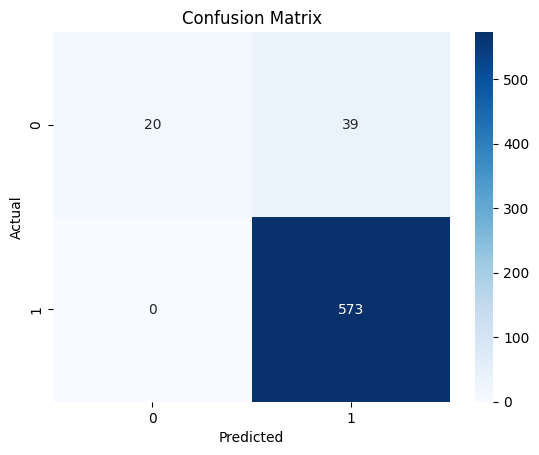

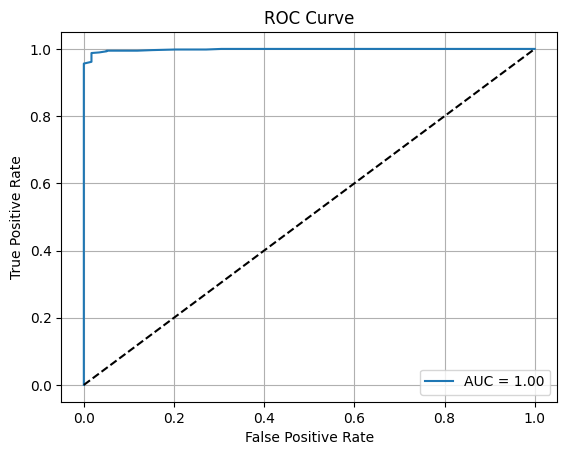

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# **Class Imbalance Handling**

In [40]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train = X_train.drop(columns=['arr_delay'])
X_test = X_test.drop(columns=['arr_delay'])

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_imputed, y_train)

rf_sm = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)

y_pred_sm = rf_sm.predict(X_test_imputed)

print("SMOTE - Classification Report:\n", classification_report(y_test, y_pred_sm))

SMOTE - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.37      0.54        59
           1       0.94      1.00      0.97       573

    accuracy                           0.94       632
   macro avg       0.97      0.69      0.76       632
weighted avg       0.95      0.94      0.93       632



# **Improving Model Performance**

Handling Class Imbalance

In [41]:
rf_sm = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = rf_sm.predict(X_test_imputed)
print("SMOTE with Class Weights - Classification Report:\n", classification_report(y_test, y_pred_sm))

SMOTE with Class Weights - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.37      0.54        59
           1       0.94      1.00      0.97       573

    accuracy                           0.94       632
   macro avg       0.97      0.69      0.76       632
weighted avg       0.95      0.94      0.93       632



Tuning the Model

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_sm, y_train_sm)
print("Best Parameters: ", grid_search.best_params_)
rf_best = grid_search.best_estimator_

y_pred_best = rf_best.predict(X_test_imputed)
print("GridSearch - Classification Report:\n", classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters:  {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
GridSearch - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.58      0.73        59
           1       0.96      1.00      0.98       573

    accuracy                           0.96       632
   macro avg       0.98      0.79      0.85       632
weighted avg       0.96      0.96      0.96       632



# **Feature Importance Analysis**

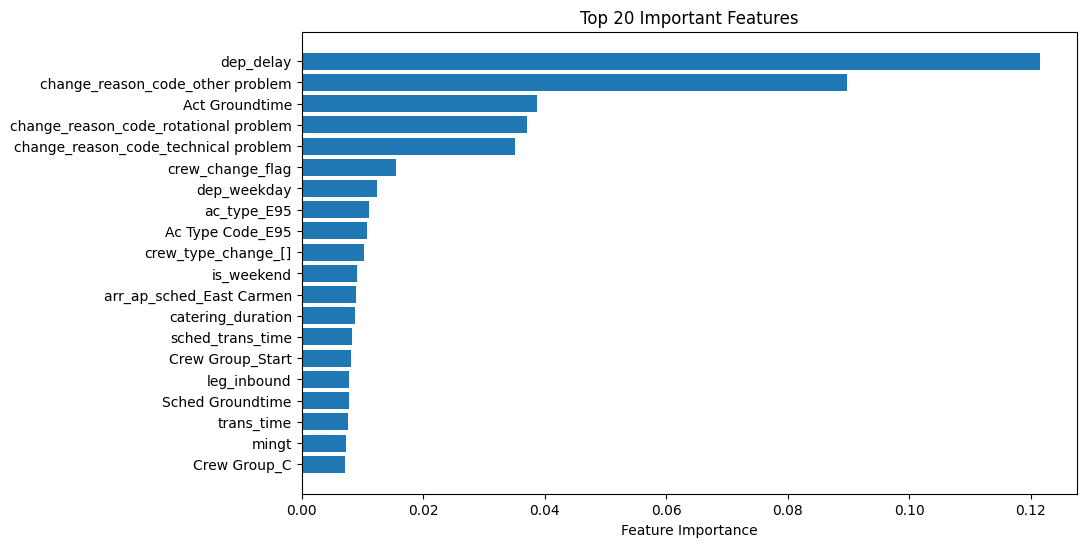

In [43]:
importances = rf_best.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis()
plt.show()